In [1]:
import os, sqlite3, pandas as pd, numpy as np
import matplotlib.pyplot as plt

db_path = "../data/covid.db"

conn = sqlite3.connect(db_path)
print("Connected to:", db_path)

tbl = "states_daily_cleaned"

# Make pandas show more
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

Connected to: ../data/covid.db


In [2]:
schema = pd.read_sql(f"PRAGMA table_info({tbl});", conn)
display(schema)

overview = pd.read_sql(
    f'''
    SELECT 
      COUNT(*) AS n_rows,
      MIN(date) AS min_date,
      MAX(date) AS max_date,
      COUNT(DISTINCT state) AS n_states
    FROM {tbl};
    ''', conn
)
display(overview)

,cid,name,type,notnull,dflt_value,pk
0,0,date,TEXT,0,None,0
1,1,state,TEXT,0,None,0
2,2,positive,REAL,0,None,0
3,3,probableCases,REAL,0,None,0
4,4,negative,REAL,0,None,0
...,...,...,...,...,...,...
40,40,hospitalizedIncrease,INTEGER,0,None,0
41,41,positive_growth_rate,REAL,0,None,0
42,42,death_growth_rate,REAL,0,None,0
43,43,positivityRate,REAL,0,None,0


,n_rows,min_date,max_date,n_states
0,20780,2020-01-13,2021-03-07,56


There are 20780 rows in total, date ranges from 2020-01-13 to 2021-03-07. The data is collected on states basis, total of 56 states.

In [3]:
daily = pd.read_sql(
    f'''
    WITH daily AS (
      SELECT date,
             SUM(COALESCE(positiveIncrease,0)) AS pos_inc,
             SUM(COALESCE(deathIncrease,0))    AS death_inc,
             SUM(COALESCE(totalTestResultsIncrease,0)) AS tests_inc
      FROM {tbl}
      GROUP BY date
    )
    SELECT date,
           pos_inc, death_inc, tests_inc,
           CASE WHEN tests_inc > 0 THEN 1.0*pos_inc/tests_inc END AS positivity,
           CASE WHEN pos_inc > 0 THEN 1.0*death_inc/pos_inc END AS cfr
    FROM daily
    ORDER BY date;
    ''', conn
)

# Parse date if it's in yyyymmdd numeric/string format
def to_datetime_maybe(x):
    s = str(x)
    if len(s) == 8 and s.isdigit():
        return pd.to_datetime(s, format="%Y%m%d")
    return pd.to_datetime(s, errors="coerce")

daily["date"] = daily["date"].apply(to_datetime_maybe)
daily = daily.sort_values("date").reset_index(drop=True)

display(daily.head(10))
display(daily.tail(10))

,date,pos_inc,death_inc,tests_inc,positivity,cfr
0,2020-01-13,0,0,0,NaN,NaN
1,2020-01-14,0,0,0,NaN,NaN
2,2020-01-15,0,0,0,NaN,NaN
3,2020-01-16,0,0,0,NaN,NaN
4,2020-01-17,0,0,0,NaN,NaN
5,2020-01-18,0,0,0,NaN,NaN
6,2020-01-19,1,0,0,NaN,0.0
7,2020-01-20,0,0,0,NaN,NaN
8,2020-01-21,1,0,0,NaN,0.0
9,2020-01-22,0,0,0,NaN,NaN


,date,pos_inc,death_inc,tests_inc,positivity,cfr
410,2021-02-26,74857,2141,1803309,0.041511,0.028601
411,2021-02-27,71245,1847,1655179,0.043044,0.025925
412,2021-02-28,54349,1051,1408422,0.038589,0.019338
413,2021-03-01,48092,1241,1154440,0.041658,0.025805
414,2021-03-02,54248,1728,1343519,0.040378,0.031854
415,2021-03-03,66836,2449,1406795,0.047509,0.036642
416,2021-03-04,65487,1743,1590984,0.041161,0.026616
417,2021-03-05,68787,2221,1744417,0.039433,0.032288
418,2021-03-06,60015,1680,1430992,0.041939,0.027993
419,2021-03-07,41835,842,1170059,0.035755,0.020127


As we can see, the covid doesn't spread at the beginning of 2020, but at 2021, there seems to be a lot.

In [4]:
# ---  7-day moving averages ---
for col in ["pos_inc", "death_inc", "tests_inc", "positivity", "cfr"]:
    if col in daily:
        daily[col + "_7dma"] = daily[col].rolling(7, min_periods=1).mean()

display(daily.tail(14))

,date,pos_inc,death_inc,tests_inc,positivity,cfr,pos_inc_7dma,death_inc_7dma,tests_inc_7dma,positivity_7dma,cfr_7dma
406,2021-02-22,52530,1235,1201247,0.043730,0.023510,64033.857143,1925.142857,1.328675e+06,0.048820,0.029537
407,2021-02-23,69105,2241,1193835,0.057885,0.032429,65861.428571,2052.000000,1.348694e+06,0.049455,0.030738
408,2021-02-24,73258,2447,1450666,0.050500,0.033402,66778.428571,2066.142857,1.370444e+06,0.049315,0.030491
409,2021-02-25,75565,3138,1826144,0.041380,0.041527,68027.142857,2140.714286,1.439057e+06,0.048133,0.030831
410,2021-02-26,74857,2141,1803309,0.041511,0.028601,68053.000000,2092.714286,1.428382e+06,0.048383,0.030178
411,2021-02-27,71245,1847,1655179,0.043044,0.025925,67894.571429,2048.000000,1.480482e+06,0.046522,0.029617
412,2021-02-28,54349,1051,1408422,0.038589,0.019338,67272.714286,2014.285714,1.505543e+06,0.045234,0.029248
413,2021-03-01,48092,1241,1154440,0.041658,0.025805,66638.714286,2015.142857,1.498856e+06,0.044938,0.029575
414,2021-03-02,54248,1728,1343519,0.040378,0.031854,64516.285714,1941.857143,1.520240e+06,0.042437,0.029493
415,2021-03-03,66836,2449,1406795,0.047509,0.036642,63598.857143,1942.142857,1.513973e+06,0.042010,0.029956


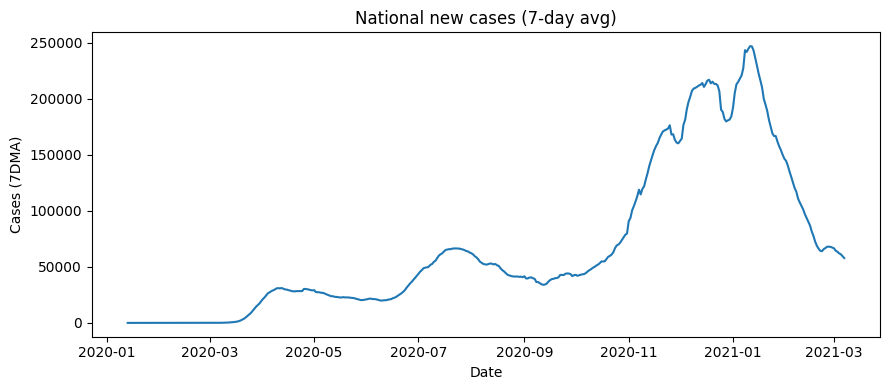

In [5]:
# ---  national cases 7-day average ---
plt.figure(figsize=(9,4))
plt.plot(daily["date"], daily["pos_inc_7dma"])
plt.title("National new cases (7-day avg)")
plt.xlabel("Date")
plt.ylabel("Cases (7DMA)")
plt.tight_layout()
plt.show()

From the 7 days moving average new cases plot, we can roughly see that covid peaks at around 2021-01.

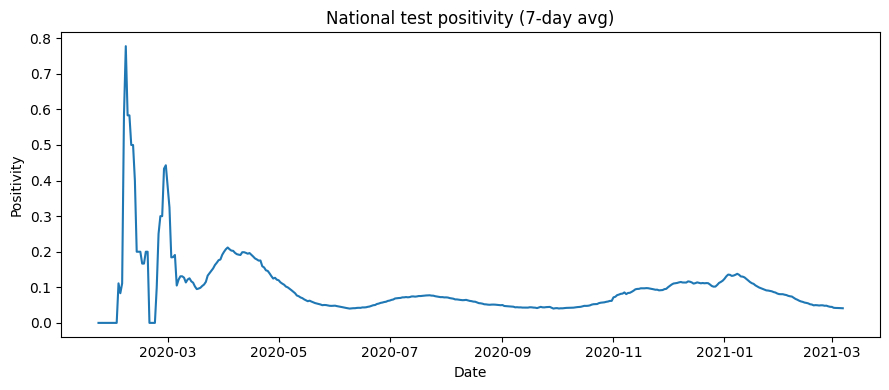

In [6]:
# --- Plot – national test positivity (7-day avg) ---
plt.figure(figsize=(9,4))
plt.plot(daily["date"], daily["positivity_7dma"])
plt.title("National test positivity (7-day avg)")
plt.xlabel("Date")
plt.ylabel("Positivity")
plt.tight_layout()
plt.show()

At the very beginning of the pandemic the positivity rate spiked extremely high. That tells us testing was scarce and mostly given to people who were already very likely to be sick, so a big share of tests came back positive. As testing expanded, the rate fell quickly and then settled into waves: a summer bump, a larger fall–winter rise, and then a steady decline into early 2021. When the line goes up, it suggests faster community spread and/or not enough testing; when it goes down, it suggests broader testing and/or easing transmission. Overall, the picture fits the story of early under-testing, followed by better coverage and seasonal waves, with the winter wave peaking lower than the initial “under-testing” spike.

In [8]:
# --- Top states by total cases & deaths ---
leaders = pd.read_sql(
    f'''
    SELECT state,
           SUM(COALESCE(positiveIncrease,0)) AS total_cases,
           SUM(COALESCE(deathIncrease,0))    AS total_deaths
    FROM {tbl}
    GROUP BY state
    ORDER BY total_cases DESC;
    ''', conn
)
display(leaders.head(15))

,state,total_cases,total_deaths
0,CA,3501341,54124
1,TX,2686818,44451
2,FL,1909209,32266
3,NY,1681169,39029
4,IL,1198331,23014
5,GA,1023485,17906
6,OH,978471,17656
7,PA,948643,24349
8,NC,872175,11502
9,AZ,826452,16328


California has the most total cases and deaths, with Texas and Florida next. Big-population states dominate the totals; New York’s deaths are high relative to its cases, likely from the early surge. A per-capita view could change the ranking.

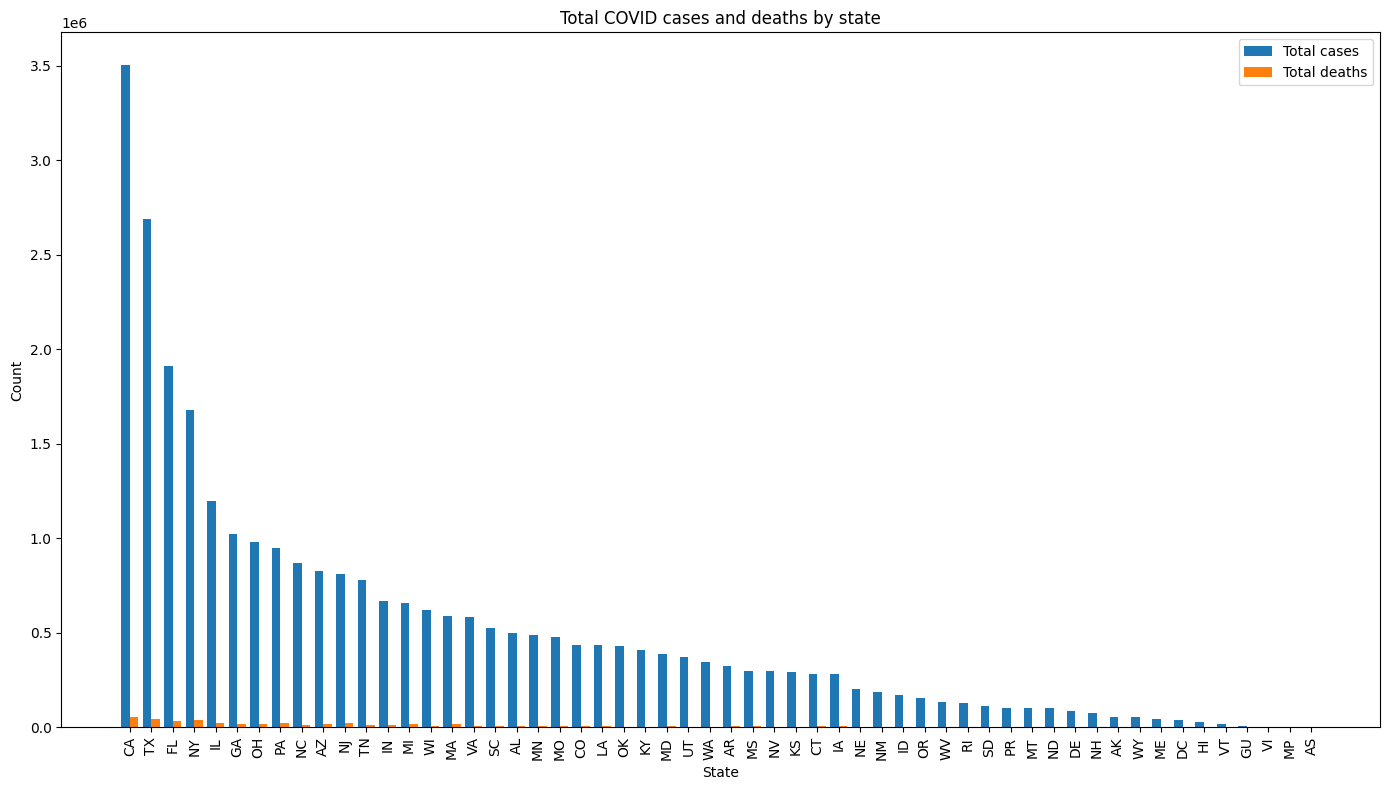

In [ ]:
leaders_sorted = leaders.sort_values("total_cases", ascending=False)
plt.figure(figsize=(14, 8))

x = np.arange(len(leaders_sorted))      
width = 0.4                          

plt.bar(x - width/2, leaders_sorted["total_cases"],  width, label="Total cases")
plt.bar(x + width/2, leaders_sorted["total_deaths"], width, label="Total deaths")

plt.xticks(x, leaders_sorted["state"], rotation=90)
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Total COVID cases and deaths by state")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# --- Latest day snapshot (positivity & CFR extremes) ---
last_date = pd.read_sql(f"SELECT MAX(date) AS d FROM {tbl};", conn)["d"].iloc[0]

latest = pd.read_sql(
    f'''
    SELECT state,
           positiveIncrease, totalTestResultsIncrease,
           positivityRate, caseFatalityRate, deathIncrease
    FROM {tbl}
    WHERE date = :d;
    ''', conn, params={"d": last_date}
)

# Clean & sort
lat_sorted_pos = latest.dropna(subset=["positivityRate"]).sort_values("positivityRate", ascending=False)
lat_sorted_cfr = latest.dropna(subset=["caseFatalityRate"]).sort_values("caseFatalityRate", ascending=False)

print("Latest date:", last_date)
print("\nTop 10 states by daily positivityRate on latest date:")
display(lat_sorted_pos.head(10))

print("\nTop 10 states by daily caseFatalityRate on latest date:")
display(lat_sorted_cfr.head(10))

Latest date: 2021-03-07

Top 10 states by daily positivityRate on latest date:


,state,positiveIncrease,totalTestResultsIncrease,positivityRate,caseFatalityRate,deathIncrease
32,NE,373,1,373.000,0.010,0
28,MS,260,260,1.000,0.023,3
42,PR,305,305,1.000,0.020,3
39,OK,461,461,1.000,0.011,0
34,NJ,2519,2519,1.000,0.029,17
27,MP,1,1,1.000,0.014,0
15,ID,104,396,0.263,0.011,3
1,AL,408,2347,0.174,0.020,-1
14,IA,257,1556,0.165,0.020,6
45,SD,211,1275,0.165,0.017,2



Top 10 states by daily caseFatalityRate on latest date:


,state,positiveIncrease,totalTestResultsIncrease,positivityRate,caseFatalityRate,deathIncrease
34,NJ,2519,2519,1.000,0.029,17
21,MA,1425,96578,0.015,0.028,43
7,CT,0,0,0.000,0.027,0
41,PA,1658,52432,0.032,0.026,32
24,MI,0,0,0.000,0.025,0
8,DC,146,5726,0.025,0.025,0
28,MS,260,260,1.000,0.023,3
37,NY,6789,227768,0.030,0.023,59
20,LA,740,21318,0.035,0.022,32
22,MD,709,33128,0.021,0.021,14


In [ ]:
# --- Per-state surge peaks (7-day avg of new cases) ---
surges = pd.read_sql(
    f'''
    WITH per_day AS (
      SELECT state, date, COALESCE(positiveIncrease,0) AS cases
      FROM {tbl}
    ),
    rolling AS (
      SELECT state, date, cases,
             AVG(cases) OVER (
                 PARTITION BY state
                 ORDER BY date
                 ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
             ) AS ma7
      FROM per_day
    ),
    ranked AS (
      SELECT state, date, ma7,
             ROW_NUMBER() OVER (PARTITION BY state ORDER BY ma7 DESC, date DESC) AS rn
      FROM rolling
    )
    SELECT state, date, ma7 AS peak_7dma_cases
    FROM ranked
    WHERE rn = 1
    ORDER BY peak_7dma_cases DESC
    LIMIT 20;
    ''', conn
)

# Parse date for readability
def _td(x):
    s = str(x)
    if len(s) == 8 and s.isdigit():
        return pd.to_datetime(s, format="%Y%m%d")
    return pd.to_datetime(s, errors="coerce")

surges["date"] = surges["date"].apply(_td)
display(surges)

,state,date,peak_7dma_cases
0,CA,2020-12-22,43948.142857
1,TX,2021-01-09,23043.571429
2,FL,2021-01-08,17568.857143
3,NY,2021-01-12,16334.571429
4,OH,2020-12-13,12529.000000
5,IL,2020-11-16,12384.000000
6,PA,2020-12-16,10578.857143
7,AZ,2021-01-12,9803.714286
8,GA,2021-01-13,9778.285714
9,TN,2020-12-18,9627.000000


,state,date,peak_7dma_cases
0,CA,2020-12-22,43948.142857
1,TX,2021-01-09,23043.571429
2,FL,2021-01-08,17568.857143
3,NY,2021-01-12,16334.571429
4,OH,2020-12-13,12529.000000


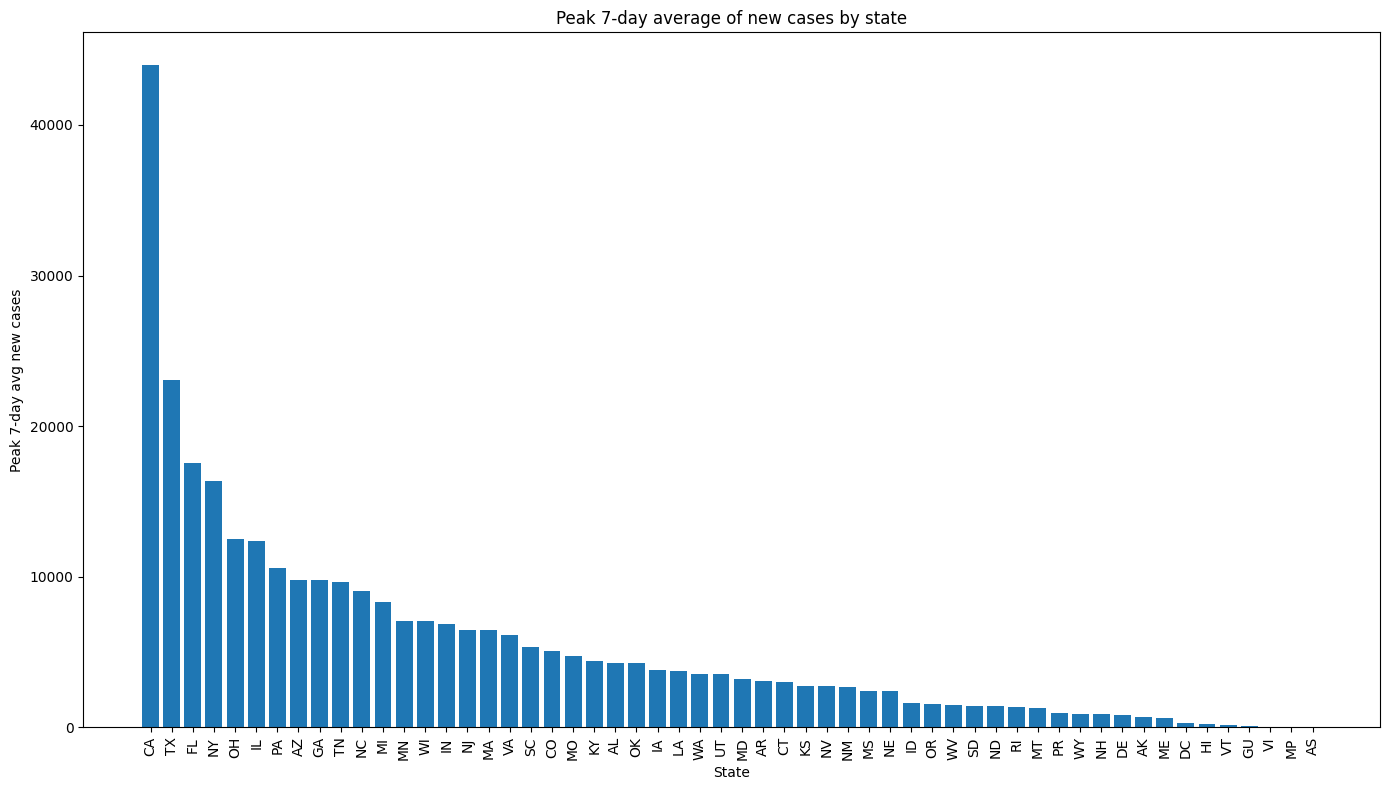

In [11]:
surges = pd.read_sql(
    f'''
    WITH per_day AS (
      SELECT state, date, COALESCE(positiveIncrease,0) AS cases
      FROM {tbl}
    ),
    rolling AS (
      SELECT state, date, cases,
             AVG(cases) OVER (
                 PARTITION BY state
                 ORDER BY date
                 ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
             ) AS ma7
      FROM per_day
    ),
    ranked AS (
      SELECT state, date, ma7,
             ROW_NUMBER() OVER (
                 PARTITION BY state
                 ORDER BY ma7 DESC, date DESC
             ) AS rn
      FROM rolling
    )
    SELECT state, date, ma7 AS peak_7dma_cases
    FROM ranked
    WHERE rn = 1
    ORDER BY peak_7dma_cases DESC;
    ''', conn
)

# 解析日期
def _td(x):
    s = str(x)
    if len(s) == 8 and s.isdigit():
        return pd.to_datetime(s, format="%Y%m%d")
    return pd.to_datetime(s, errors="coerce")

surges["date"] = surges["date"].apply(_td)

display(surges.head())


import matplotlib.pyplot as plt
import numpy as np

# sort by peak value (optional, just to make the plot nicer)
surges_sorted = surges.sort_values("peak_7dma_cases", ascending=False)

x = np.arange(len(surges_sorted))

plt.figure(figsize=(14, 8))
plt.bar(x, surges_sorted["peak_7dma_cases"])

plt.xticks(x, surges_sorted["state"], rotation=90)
plt.xlabel("State")
plt.ylabel("Peak 7-day avg new cases")
plt.title("Peak 7-day average of new cases by state")
plt.tight_layout()
plt.show()


California had the biggest peak. Many states peaked in early January 2021 (TX, FL, NY), while several Midwest states peaked earlier in November–early December (IL, MN, WI, CO, MI). This shows the winter surge hit regions at different times; a per-capita view could change the ranking.

In [36]:
# --- National hospitalization & ICU trends ---
hosp = pd.read_sql(
    f'''
    SELECT date,
           SUM(COALESCE(hospitalizedCurrently,0))  AS hosp_cur,
           SUM(COALESCE(inIcuCurrently,0))         AS icu_cur,
           SUM(COALESCE(onVentilatorCurrently,0))  AS vent_cur
    FROM {tbl}
    GROUP BY date
    ORDER BY date;
    ''', conn
)

hosp["date"] = pd.to_datetime(hosp["date"], errors="coerce")
hosp = hosp.sort_values("date").reset_index(drop=True)

# 7-day averages
for c in ["hosp_cur", "icu_cur", "vent_cur"]:
    hosp[c+"_7dma"] = hosp[c].rolling(7, min_periods=1).mean()

display(hosp.tail(14))

,date,hosp_cur,icu_cur,vent_cur,hosp_cur_7dma,icu_cur_7dma,vent_cur_7dma
406,2021-02-22,55406.0,11617.0,4226.0,59956.714286,12616.142857,4512.714286
407,2021-02-23,55061.0,11353.0,4177.0,58614.000000,12282.571429,4418.428571
408,2021-02-24,54121.0,11107.0,4107.0,57298.142857,11987.142857,4334.714286
409,2021-02-25,52672.0,10927.0,3989.0,55933.142857,11674.285714,4247.142857
410,2021-02-26,51115.0,10547.0,3888.0,54680.285714,11385.000000,4154.000000
411,2021-02-27,48874.0,10195.0,3757.0,53344.428571,11098.428571,4068.714286
412,2021-02-28,47355.0,9883.0,3667.0,52086.285714,10804.142857,3973.000000
413,2021-03-01,46741.0,9676.0,3593.0,50848.428571,10526.857143,3882.571429
414,2021-03-02,46391.0,9546.0,3591.0,49609.857143,10268.714286,3798.857143
415,2021-03-03,45465.0,9440.0,3516.0,48373.285714,10030.571429,3714.428571


From Feb 22 to Mar 7, 2021 the counts steadily fall: hospitalized ~55k → ~40k (≈ −27%), ICU ~11.6k → ~8.2k (≈ −29%), ventilated ~4.2k → ~3.2k (≈ −24%). The mix is stable: ICU is about 20–21% of hospitalized, and ventilated is ~36–39% of ICU. The 7-day averages trend down too, so this looks like a sustained post-winter-wave decline rather than a one-day dip.

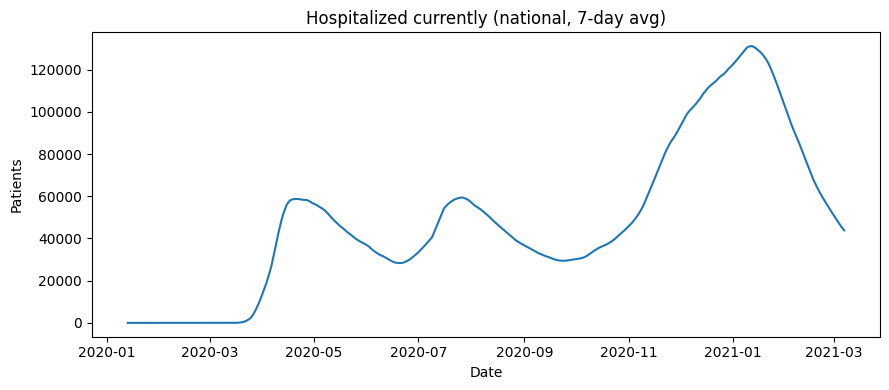

In [40]:
# --- Plot – hospitalized currently (7DMA) ---
plt.figure(figsize=(9,4))
plt.plot(hosp["date"], hosp["hosp_cur_7dma"])
plt.title("Hospitalized currently (national, 7-day avg)")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.tight_layout()
plt.show()

There are three waves: a spring 2020 rise, a summer bump, and a large winter surge.


The winter wave (Nov 2020 → Jan 2021) climbs fast and peaks much higher than the earlier waves, then drops through Feb–Mar 2021.


The line is a 7-day average, so it smooths weekend/reporting noise and shows the true trend.


This pattern matches cases: hospitalizations lag cases by ~1–2 weeks, and the winter surge created the heaviest hospital load.



In [38]:
# ---  Correlations between cases/tests/positivity ---
corr = daily[["pos_inc", "death_inc", "tests_inc", "positivity"]].corr(method="pearson")
display(corr)

,pos_inc,death_inc,tests_inc,positivity
pos_inc,1.000000,0.715156,0.887623,-0.010176
death_inc,0.715156,1.000000,0.670550,-0.014863
tests_inc,0.887623,0.670550,1.000000,-0.153004
positivity,-0.010176,-0.014863,-0.153004,1.000000


Cases and tests move together (corr ≈ 0.89): when you test more, you detect more cases.

Deaths move with cases (≈ 0.72), but remember deaths lag cases by ~2–3 weeks, so same-day correlation is damped.

Positivity is near zero / slightly negative vs cases and tests (≈ −0.01 and −0.15): when testing expands, the denominator grows, pushing the rate down even if spread is steady—so same-day positivity won’t track cases well.

In [41]:
conn.close()
print("Connection closed.")

Connection closed.
